# Анализ поведения пользователей продающего приложения (Сборный проект 2)

Мы работаем в стартапе. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

Исходя из опасений менеджеров сформировали цель исследования.

**Цель исследования:**
* Как повлияло изменение шрифта в приложении на поведение пользователей.

**Исследование будет проходить в несколько шагов:**
* Шаг 1. Откроем файл с данными и изучим общую информацию;
* Шаг 2. Подготовим данные;
* Шаг 3. Изучим и проверьте данные;
* Шаг 4. Изучим воронку событий;
* Шаг 5. Изучим результаты эксперимента.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
pd.set_option('display.max_colwidth', 0)

## Откроем файл с данными и изучим общую информацию

In [2]:
logs = pd.read_csv('C:\\StudentYandex\\Projekts\\Python\\Project8sbornuy2\\logs_exp.csv', sep = '\t')

In [3]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:**

Каждая запись в логе — это действие пользователя, или событие.

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовим данные

### Заменим названия столбцов

In [5]:
logs.columns = [column.lower() for column in logs.columns] # Приводим названия столбцов к нижнему регистру 

In [6]:
logs = logs.rename(columns={'expid':'group', 'deviceidhash':'visitorid'}) # Меняем названия столбцов

In [7]:
logs.head()

,eventname,visitorid,eventtimestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверим пропуски и типы данных.

In [8]:
display(logs.info()) # Получаем информацию о таблице
display(logs.duplicated().sum()) # Проверяем количество дубликатов
logs.isna().sum() # Проверяем количество пропусков в каждом столбце

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   visitorid       244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   group           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

413

eventname         0
visitorid         0
eventtimestamp    0
group             0
dtype: int64

In [9]:
logs = logs.drop_duplicates()# Удалим явные дубликаты

### Добавим столбец даты и времени, а также отдельный столбец дат

In [10]:
logs['eventdt'] = logs['eventtimestamp'].map(lambda x: dt.datetime.fromtimestamp(x)) 


In [11]:
logs['date'] = logs['eventdt'].map(lambda x: dt.datetime.date(x))

In [12]:
logs.head()

,eventname,visitorid,eventtimestamp,group,eventdt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 09:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 16:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 16:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 16:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 16:48:42,2019-07-25


**Вывод:**
* При предобработке данных заголовки столбцов привели к хорошему стилю и перерименовали;
* Пропуски в логах отсутствуют;
* Удалили явные дубликаты;
* Добавили и преобразовали столбцы с датой и временем;

## Изучим и проверим данные

### Посчитаем сколько всего событий в логе

In [13]:
logs.count()

eventname         243713
visitorid         243713
eventtimestamp    243713
group             243713
eventdt           243713
date              243713
dtype: int64

In [14]:
display(logs['eventname'].unique())
logs['eventname'].nunique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

5

### Посчитаем сколько всего пользователей в логе

In [15]:
visitorid = logs['visitorid'].nunique()
visitorid

7551

### Посчитаем сколько в среднем событий приходится на пользователя

In [16]:
round(logs.groupby('visitorid').agg({'eventtimestamp':'count'}).mean())

eventtimestamp    32.0
dtype: float64

### Посмотрим данными за какой период мы располагаем:

In [17]:
print('Минимальная дата', min(logs['date']))
print('Максимальная дата', max(logs['date']))

Минимальная дата 2019-07-25
Максимальная дата 2019-08-08


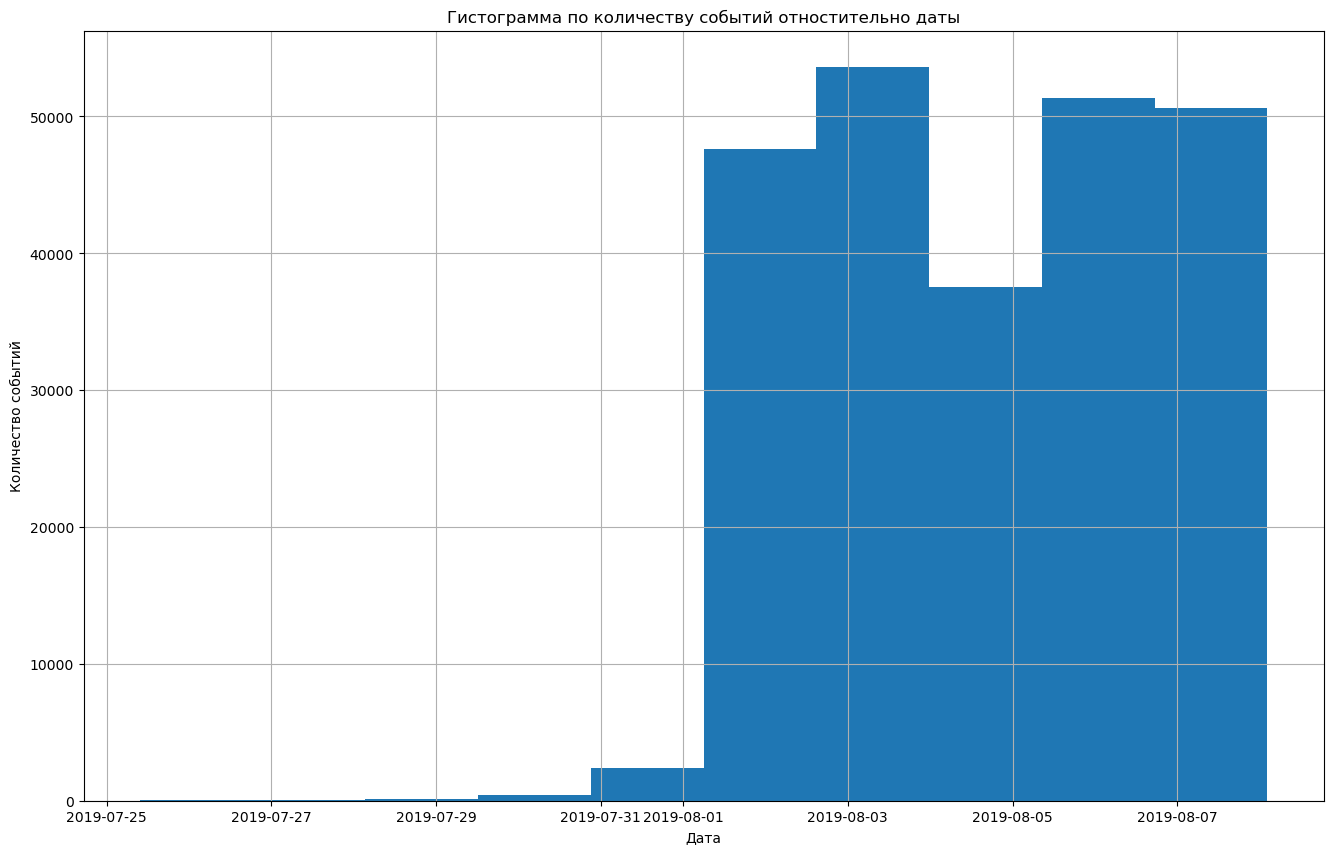

In [18]:
plt.figure(figsize=(16, 10))
logs['eventdt'].hist()
plt.title('Гистограмма по количеству событий отностительно даты')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

* По гистограмме видим что данные полные за период с 01.08.2019 по 07.08.2019

### Отбросим старые данные и посчитаем количество "событий из прошлого"

In [19]:
logs[logs['date'] < datetime(2019, 8, 1).date()]['date'].count()

1868

In [20]:
logs = logs[logs['date'] >= datetime(2019, 8, 1).date()]

In [21]:
# Считаем потери уникальных пользователей
visitorid - logs['visitorid'].nunique()

12

### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [22]:
logs.groupby('group').agg({'eventname':'count'})

,eventname
group,
246,79591
247,77339
248,84915


**Вывод:**
* В логе всего 5 событий: 'MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial';
* На одного пользователя в среднем приходится 32 события;
* В нашем распоряжении данные с 25.07.2019 по 07.08.2019;
* Было всего 2826 событий и 17 пользователей за период с 25.07.2019 по 01.08.2019 - исключили их из анализа, т.к. есть сомнения по поводу полноты данных за этот период;
* В базе есть данные по всем трем экпериментальным группам;

##  Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

,date
eventname,
MainScreenAppear,117955
OffersScreenAppear,46559
CartScreenAppear,42361
PaymentScreenSuccessful,33960
Tutorial,1010


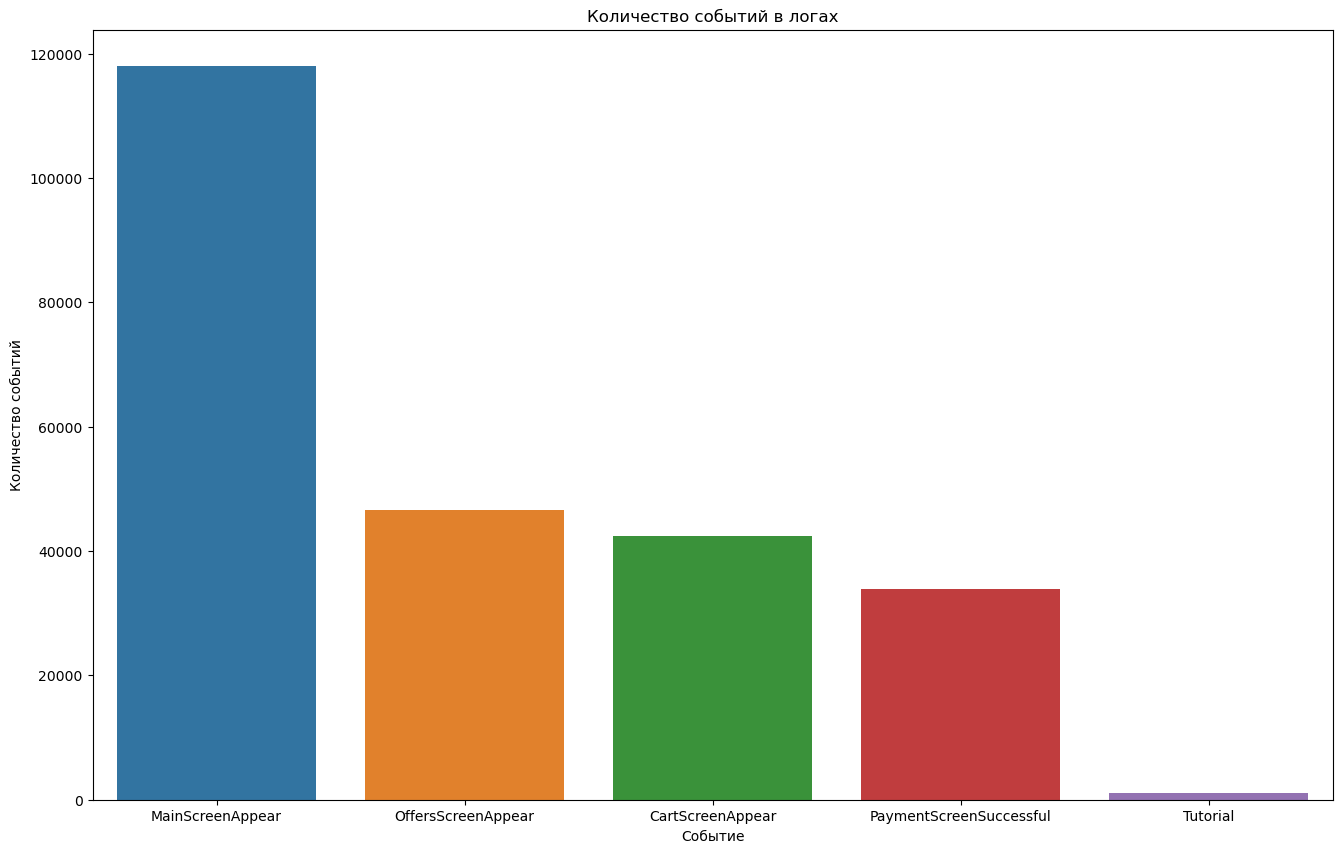

In [23]:
data = logs.groupby('eventname').agg({'date':'count'}).sort_values(by = 'date', ascending = False)
display(data)
plt.figure(figsize=(16, 10))
(sns.barplot(data = data, y = 'date', x = data.index)
    .set(title = 'Количество событий в логах', xlabel = 'Событие', ylabel = 'Количество событий'))
plt.show()

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [24]:
data = logs.groupby('eventname').agg({'visitorid':'nunique'}).sort_values(by = 'visitorid', ascending = False)
data

,visitorid
eventname,
MainScreenAppear,7424
OffersScreenAppear,4599
CartScreenAppear,3736
PaymentScreenSuccessful,3540
Tutorial,843


In [25]:
sum_visitors = logs['visitorid'].nunique()
sum_visitors

7539

In [26]:
data['percent'] = round((data['visitorid']/sum_visitors)*100)
data

,visitorid,percent
eventname,,
MainScreenAppear,7424,98.0
OffersScreenAppear,4599,61.0
CartScreenAppear,3736,50.0
PaymentScreenSuccessful,3540,47.0
Tutorial,843,11.0


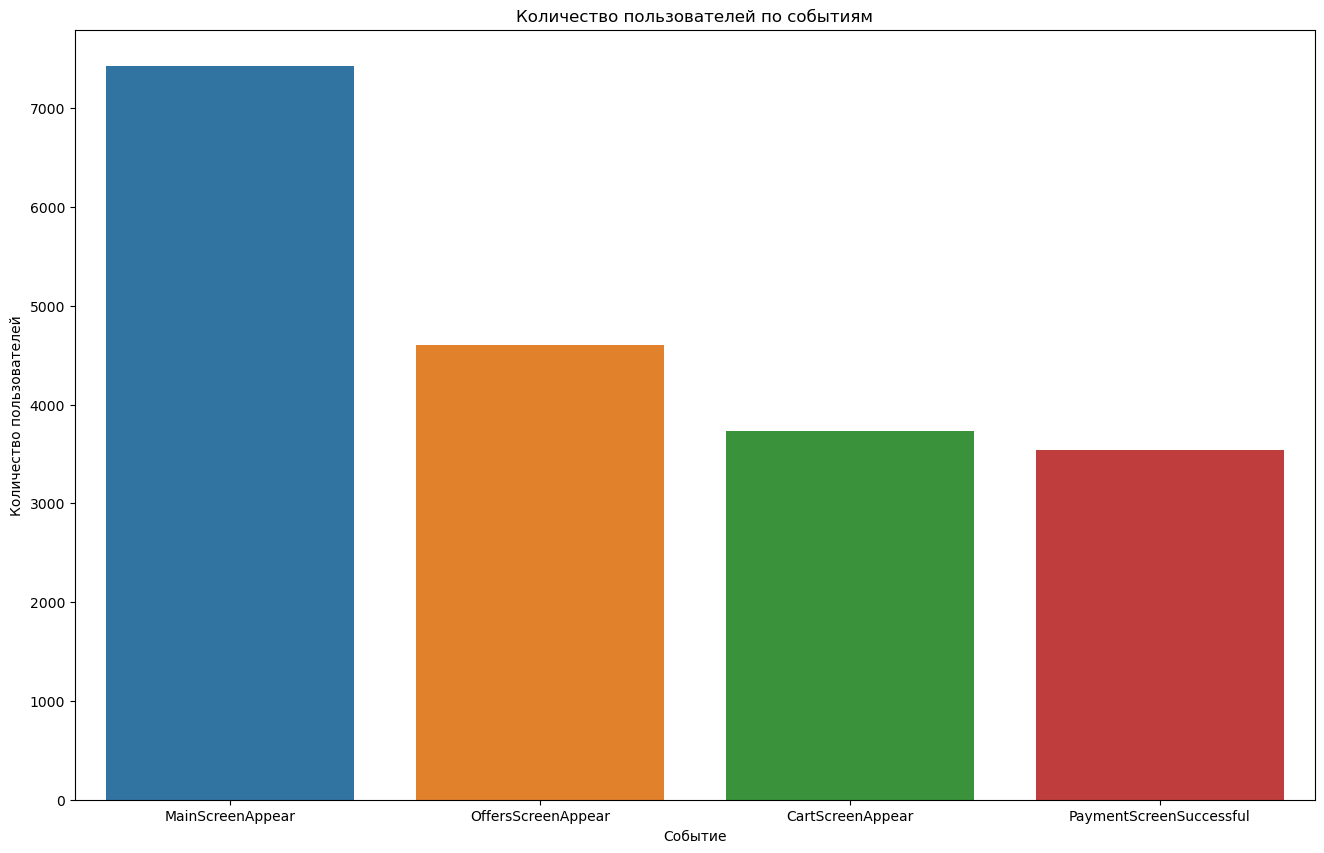

In [27]:
data = data[data.index != 'Tutorial']
plt.figure(figsize=(16, 10))
(sns.barplot(data = data, y = 'visitorid', x = data.index)
    .set(title = 'Количество пользователей по событиям', xlabel = 'Событие', ylabel = 'Количество пользователей'))
plt.show()

### Порядок в котором происходят события

Посмотрев воронку событий и количество пользователей по кадому событию можно предположитьчто порядок событий такой:
1. MainScreenAppear	(Появится главный экран);
2. OffersScreenAppear (Появится экран предложений);
3. CartScreenAppear	(Появится экран корзины);
4. PaymentScreenSuccessful (Экран оплаты прошел успешно).

Событие Tutorial (Руководство) - не обязательное, к нему обращаются пользователи для получения подсказок в ходе покупки. Но надо будет проверить смогли ли пользователи после обращения к подсказке продолжить покупку.

98% от всех пользователей приходят на главный экран, 61% на экран предложений, 50% переходят на экран корзины, 47% на экран оплаты прошел успешно и только 11% заходят в руководство

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [28]:
data = logs.groupby('eventname').agg({'visitorid':'nunique'}).sort_values(by = 'visitorid', ascending = False).reset_index()

In [29]:
data.columns = ['eventname','count_visitors']

In [30]:
# исключаем из воронки Tutorial
data = data[data['eventname'] != 'Tutorial']
data['fraction'] = data['count_visitors']
logs = logs[logs['eventname'] != 'Tutorial']

In [31]:
for i in data.index:
    try:        
        if i == 0:
            data.loc[i, 'fraction'] = 0
        else:
            data.loc[i, 'fraction'] = round((data['count_visitors'][i]/data['count_visitors'][i-1])*100)
    except:
        pass

In [32]:
data

,eventname,count_visitors,fraction
0,MainScreenAppear,7424,0
1,OffersScreenAppear,4599,62
2,CartScreenAppear,3736,81
3,PaymentScreenSuccessful,3540,95


In [33]:
# считаем сколько пользователей доходит от первого события до оплаты
round((data['count_visitors'][3]/data['count_visitors'][0])*100)

48

**Вывод:**

* Больше всего пользователей теряются между первым и вторым этапом ~ 39%;
* До события оплата доходит 48 % пользователей от первого события;

## Изучим результаты эксперимента

### Посмотрим сколько пользователей в каждой экспериментальной группе

In [34]:
logs.head()

,eventname,visitorid,eventtimestamp,group,eventdt,date
1869,MainScreenAppear,5522310194885794315,1564599640,247,2019-08-01 00:00:40,2019-08-01
1870,MainScreenAppear,3211698728226180240,1564599646,247,2019-08-01 00:00:46,2019-08-01
1871,MainScreenAppear,1390588986616082110,1564599680,247,2019-08-01 00:01:20,2019-08-01
1872,MainScreenAppear,5522310194885794315,1564599749,247,2019-08-01 00:02:29,2019-08-01
1873,OffersScreenAppear,5476114506218237691,1564599827,247,2019-08-01 00:03:47,2019-08-01


In [35]:
logs.groupby('group').agg({'visitorid':'nunique'})

,visitorid
group,
246,2483
247,2516
248,2536


In [36]:
# проверяем есть ли пользователи которые попали в 2 и более группы
logs.groupby('visitorid').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

### Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

Построим сводную таблицу по событию, группе и количеству уникальных пользователей:

In [37]:
event_per_groups = logs.pivot_table(index = 'eventname',columns = 'group',values = 'visitorid', aggfunc = 'nunique')\
.sort_values(by = 246, ascending = False).reset_index()
event_per_groups

group,eventname,246,247,248
0,MainScreenAppear,2450,2479,2495
1,OffersScreenAppear,1542,1525,1532
2,CartScreenAppear,1266,1239,1231
3,PaymentScreenSuccessful,1200,1158,1182


**Сделаем функцию для проверки гипотезы о равенстве долей для двух групп:**

* event_1 - количество пользователей совершивших действие в 1 группе

* event_2 - количество пользователей совершивших действие в 2 группе

* total_1 - количество пользователей всего в 1 группе

* total_2 - количество пользователей всего во 2 группе

* alpha - критический уровень статистической значимости

In [38]:
def z_test_value(event_1, event_2, total_1, total_2, alpha):
    # доля успешных действий в 1 группе
    share_1 = event_1/total_1
    # доля успешных действий во 2 группе
    share_2 = event_2/total_2
    # комбинированная доля
    share_combined = (event_1 + event_2)/(total_1 + total_2)
    # разница в долях между группами
    diff = share_1 - share_2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = diff/(share_combined *(1-share_combined)*(1/total_1 + 1/total_2))**0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    dist = stats.norm(0,1)
    # считаем p-value
    p_value = (1 - dist.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Сформулируем гипотезы и проведем `z-test` по каждому событию групп 246 и 247

Гипотезы:
**Нулевая: Статистических различий в долях между группами 246 и 247, по событию MainScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 247, по событию MainScreenAppear, есть.**

**alpha = 0.05**

In [39]:
event_246 = event_per_groups.loc[0, 246]
event_247 = event_per_groups.loc[0, 247]
total_246 = event_per_groups[246].sum()
total_247 = event_per_groups[247].sum()
alpha = 0.05
z_test_value(event_246, event_247, total_246, total_247, alpha)

p-значение:  0.35637224236778686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Нулевая: Статистических различий в долях между группами 246 и 247, по событию OffersScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 247, по событию OffersScreenAppear, есть**

**alpha = 0.05**

In [40]:
event_246 = event_per_groups.loc[1, 246]
event_247 = event_per_groups.loc[1, 247]
alpha = 0.05
z_test_value(event_246, event_247, total_246, total_247, alpha)

p-значение:  0.9438300063525629
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246 и 247, по событию CartScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 247, по событию CartScreenAppear, есть.**

**alpha = 0.05**

In [41]:
event_246 = event_per_groups.loc[2, 246]
event_247 = event_per_groups.loc[2, 247]
alpha = 0.05
z_test_value(event_246, event_247, total_246, total_247, alpha)

p-значение:  0.7233771516281546
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246 и 247, по событию PaymentScreenSuccessful, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 247, по событию PaymentScreenSuccessful, есть.**

**alpha = 0.05**

In [42]:
event_246 = event_per_groups.loc[3, 246]
event_247 = event_per_groups.loc[3, 247]
alpha = 0.05
z_test_value(event_246, event_247, total_246, total_247, alpha)

p-значение:  0.47218214802805614
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
* Статистически значимой разницы между группами 246 и 247 - нет, значит на результаты исследования не влияют внешние факторы которые мы не учли.

### Сравним результаты каждой из контрольных групп в отдельности по каждому событию с экспериментальной группой. А так же экспериментальную группу с объединённой контрольной группой

Для начала добавим в сводную таблицу `event_per_groups` столбец с объединенной контрольной группой

In [43]:
event_per_groups['246_247'] = event_per_groups[246] + event_per_groups[247]

In [44]:
event_per_groups

group,eventname,246,247,248,246_247
0,MainScreenAppear,2450,2479,2495,4929
1,OffersScreenAppear,1542,1525,1532,3067
2,CartScreenAppear,1266,1239,1231,2505
3,PaymentScreenSuccessful,1200,1158,1182,2358


**Сравним группы 246 и 248**

**Нулевая: Статистических различий в долях между группами 246 и 248, по событию MainScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 248, по событию MainScreenAppear, есть.**

**alpha = 0.05**

In [45]:
event_246 = event_per_groups.loc[0, 246]
event_248 = event_per_groups.loc[0, 248]
total_248 = event_per_groups[248].sum()
alpha = 0.05
z_test_value(event_246, event_248, total_246, total_248, alpha)

p-значение:  0.3472603849755036
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246 и 248, по событию OffersScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 248, по событию OffersScreenAppear, есть.**

**alpha = 0.05**

In [46]:
event_246 = event_per_groups.loc[1, 246]
event_248 = event_per_groups.loc[1, 248]
alpha = 0.05
z_test_value(event_246, event_248, total_246, total_248, alpha)

p-значение:  0.9060629046155502
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246 и 248, по событию CartScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 248, по событию CartScreenAppear, есть.**

**alpha = 0.05**

In [47]:
event_246 = event_per_groups.loc[2, 246]
event_248 = event_per_groups.loc[2, 248]
alpha = 0.05
z_test_value(event_246, event_248, total_246, total_248, alpha)

p-значение:  0.48247877957098506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246 и 248, по событию PaymentScreenSuccessful, нет.** 

**Альтернативная: Статистические различия в долях между группами 246 и 248, по событию PaymentScreenSuccessful, есть.**

**alpha = 0.05**

In [48]:
event_246 = event_per_groups.loc[3, 246]
event_248 = event_per_groups.loc[3, 248]
alpha = 0.05
z_test_value(event_246, event_248, total_246, total_248, alpha)

p-значение:  0.7391215967525937
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
* Статистически значимой разницы между группами 246 и 248(экспериментальной) - нет, значит на результаты исследования не влияют внешние факторы которые мы не учли.

**Сравним группы 247 и 248**

**Нулевая: Статистических различий в долях между группами 247 и 248, по событию MainScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 247 и 248, по событию MainScreenAppear, есть.**

**alpha = 0.05**

In [49]:
event_247 = event_per_groups.loc[0, 247]
event_248 = event_per_groups.loc[0, 248]
alpha = 0.05
z_test_value(event_247, event_248, total_247, total_248, alpha)

p-значение:  0.9870898989252077
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 247 и 248, по событию OffersScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 247 и 248, по событию OffersScreenAppear, есть.**

**alpha = 0.05**

In [50]:
event_247 = event_per_groups.loc[1, 247]
event_248 = event_per_groups.loc[1, 248]
alpha = 0.05
z_test_value(event_247, event_248, total_247, total_248, alpha)

p-значение:  0.9622449169593523
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 247 и 248, по событию CartScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 247 и 248, по событию CartScreenAppear, есть.**

**alpha = 0.05**

In [51]:
event_247 = event_per_groups.loc[2, 247]
event_248 = event_per_groups.loc[2, 248]
alpha = 0.05
z_test_value(event_247, event_248, total_247, total_248, alpha)

p-значение:  0.7285349204144302
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 247 и 248, по событию PaymentScreenSuccessful	, нет.** 

**Альтернативная: Статистические различия в долях между группами 247 и 248, по событию PaymentScreenSuccessful, есть.**

**alpha = 0.05**

In [52]:
event_247 = event_per_groups.loc[3, 247]
event_248 = event_per_groups.loc[3, 248]
alpha = 0.05
z_test_value(event_247, event_248, total_247, total_248, alpha)

p-значение:  0.699365242822227
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
* Статистически значимой разницы между группами 246 и 248(экспериментальной) - нет, значит на результаты исследования не влияют внешние факторы которые мы не учли.

**Сравним группы 246+247 и 248**

**Нулевая: Статистических различий в долях между группами 246+247 и 248, по событию MainScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246+247 и 248, по событию MainScreenAppear, есть.**

**alpha = 0.05**

In [53]:
event_246_247 = event_per_groups.loc[0, '246_247']
event_248 = event_per_groups.loc[0, 248]
total_246_247 = event_per_groups['246_247'].sum()
alpha = 0.05
z_test_value(event_246_247, event_248, total_246_247, total_248, alpha)

p-значение:  0.5799085034541913
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246+247 и 248, по событию OffersScreenAppear, нет.** 

**Альтернативная: Статистические различия в долях между группами 246+247 и 248, по событию OffersScreenAppear, есть.**

**alpha = 0.05**

In [54]:
event_246_247 = event_per_groups.loc[1, '246_247']
event_248 = event_per_groups.loc[1, 248]
alpha = 0.05
z_test_value(event_246_247, event_248, total_246_247, total_248, alpha)

p-значение:  0.9238361029197553
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246+247 и 248, по событию CartScreenAppear	, нет.** 

**Альтернативная: Статистические различия в долях между группами 246+247 и 248, по событию CartScreenAppear, есть.**

**alpha = 0.05**

In [55]:
event_246_247 = event_per_groups.loc[2, '246_247']
event_248 = event_per_groups.loc[2, 248]
alpha = 0.05
z_test_value(event_246_247, event_248, total_246_247, total_248, alpha)

p-значение:  0.5444105692059629
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Нулевая: Статистических различий в долях между группами 246+247 и 248, по событию PaymentScreenSuccessful, нет.** 

**Альтернативная: Статистические различия в долях между группами 246+247 и 248, по событию PaymentScreenSuccessful, есть.**

**alpha = 0.05**

In [56]:
event_246_247 = event_per_groups.loc[3, '246_247']
event_248 = event_per_groups.loc[3, 248]
alpha = 0.05
z_test_value(event_246_247, event_248, total_246_247, total_248, alpha)

p-значение:  0.9774688981310373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
* Статистически значимой разницы между группами 246+247(объединенной) и 248(экспериментальной) - нет, значит на результаты исследования не влияют внешние факторы которые мы не учли.

In [57]:
event_per_groups['p246'] = event_per_groups[246]/event_per_groups[246].sum()
event_per_groups['p247'] = event_per_groups[247]/event_per_groups[247].sum()
event_per_groups['p248'] = event_per_groups[248]/event_per_groups[248].sum()

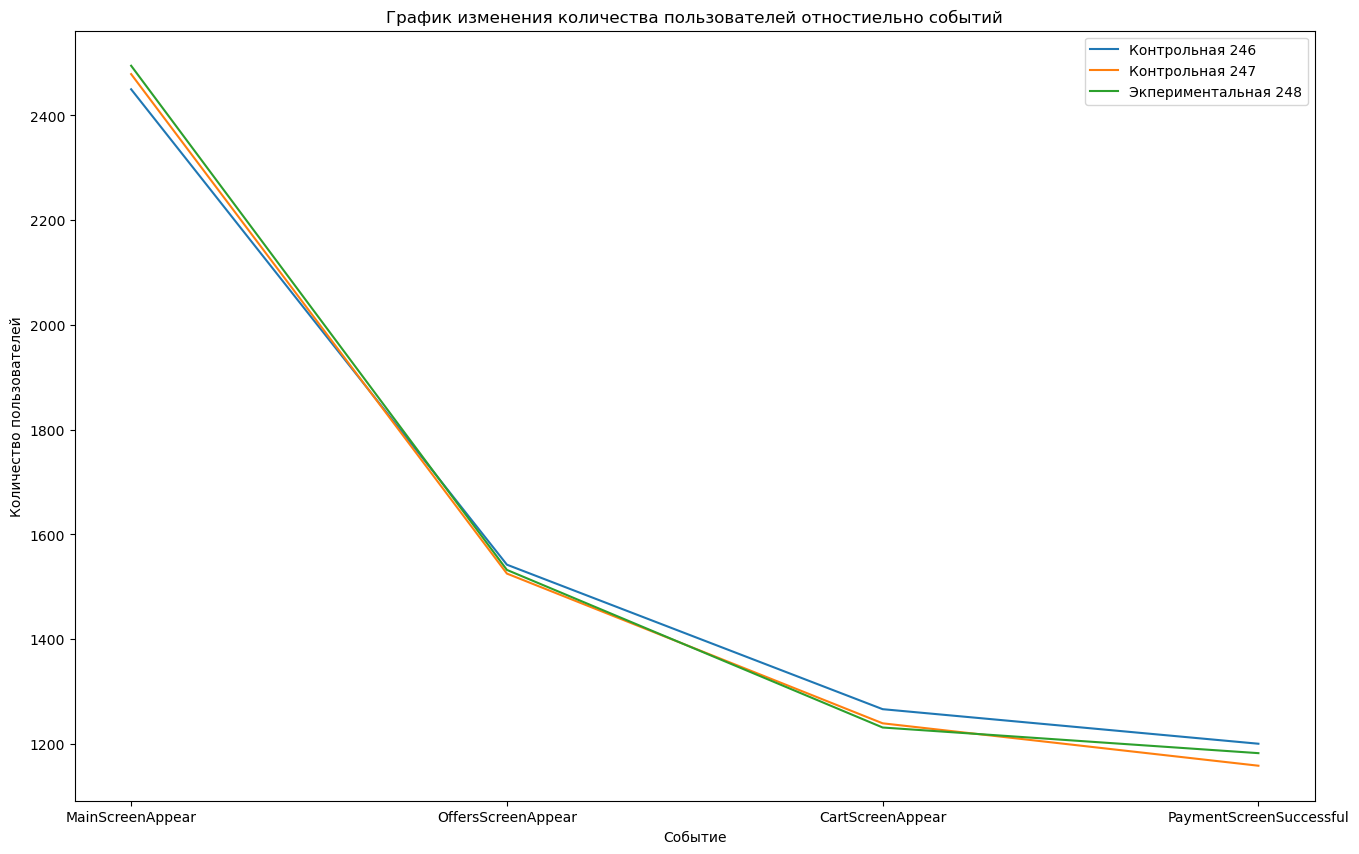

In [58]:
plt.figure(figsize=(16, 10))
# строим графики
plt.plot(event_per_groups['eventname'], event_per_groups[246], label='Контрольная 246')
plt.plot(event_per_groups['eventname'], event_per_groups[247], label='Контрольная 247')
plt.plot(event_per_groups['eventname'], event_per_groups[248], label='Экпериментальная 248')
plt.legend()
plt.title('График изменения количества пользователей отностиельно событий')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')
plt.show()

In [59]:
event_per_groups

group,eventname,246,247,248,246_247,p246,p247,p248
0,MainScreenAppear,2450,2479,2495,4929,0.379374,0.387283,0.387422
1,OffersScreenAppear,1542,1525,1532,3067,0.238774,0.238244,0.237888
2,CartScreenAppear,1266,1239,1231,2505,0.196036,0.193564,0.191149
3,PaymentScreenSuccessful,1200,1158,1182,2358,0.185816,0.180909,0.183540


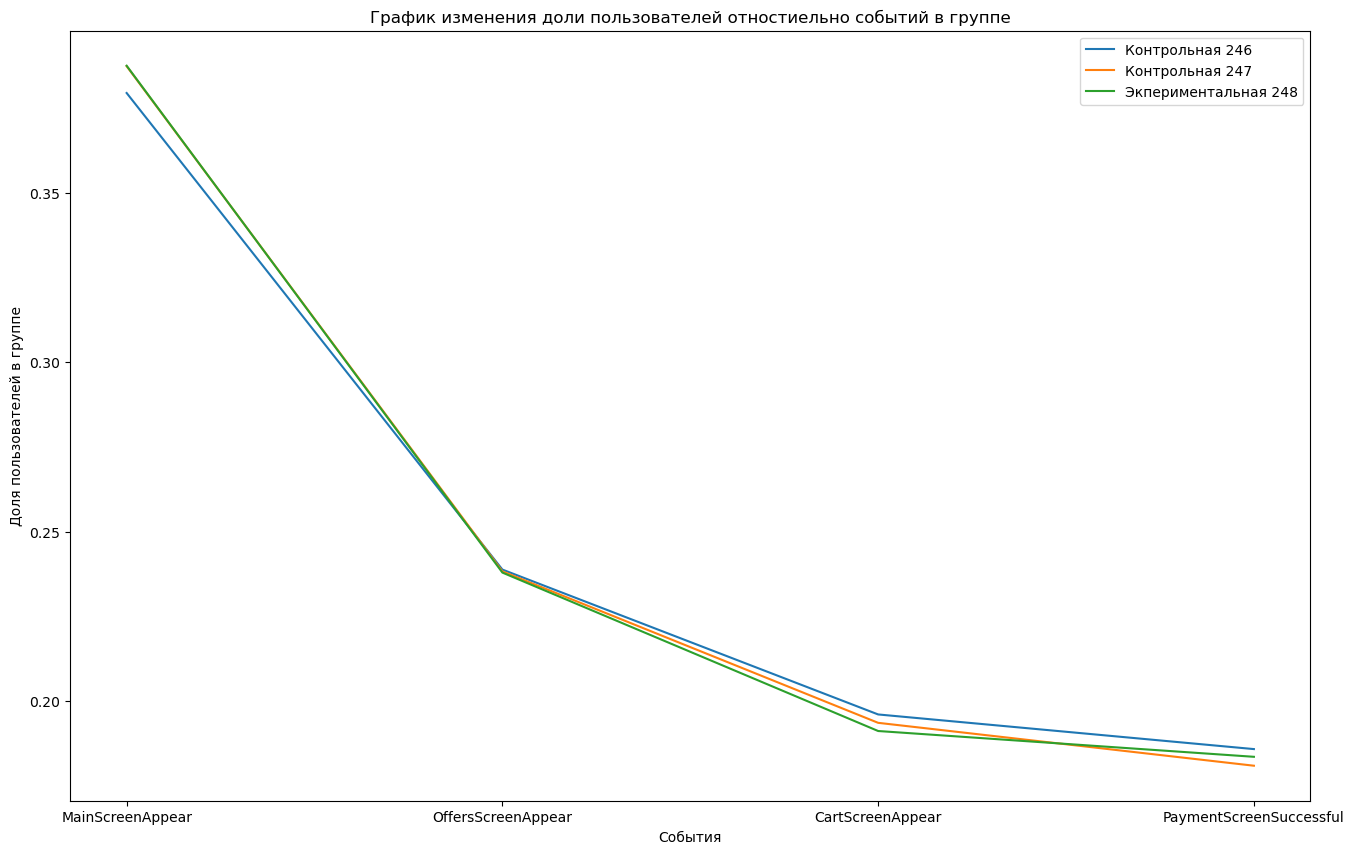

In [60]:
plt.figure(figsize=(16, 10))
# строим графики
plt.plot(event_per_groups['eventname'], event_per_groups['p246'], label='Контрольная 246')
plt.plot(event_per_groups['eventname'], event_per_groups['p247'], label='Контрольная 247')
plt.plot(event_per_groups['eventname'], event_per_groups['p248'], label='Экпериментальная 248')
plt.legend()
plt.title('График изменения доли пользователей отностиельно событий в группе')
plt.xlabel('События')
plt.ylabel('Доля пользователей в группе')
plt.show()

**Вывод:**
* Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.
* Судя по графикам можем сказать, что на поведение пользователей изменение шрифта значимого эффекта(как положительного так и отрицательного) не оказало.

# Общий вывод

Мы провели исследование поведения пользователей продающего приложения до и после изменений в приложении. Такие выводы мы получили:
* Анализируя гистограмму по дате и времени, мы приняли решение отбросить неполные данные и оставить только период с 01.08.2019;
* При исследовании воронки событий мы выяснили, что от первого события до оплаты доходит меньше половины пользователей ~ 48%;
* Только 98,5% всех пользователей хотя бы раз открывали главную страницу приложения (возможно оставшиеся пользователи не смогли попасть на главную страницу из-за ошибок/некорректной работы приложения).
* Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.

* При уровне значимости 0.1 ни одна из проверок не покажет значимую разницу между группами. И при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05.

* Исходя из результатов данного A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Что можно считать успехом, т.к. целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.